## Plot the truth and reconstructed fluences

In [13]:
import os, pickle
# jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_platform_name", "cpu")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from radiotools import helper as hp
from radiotools.coordinatesystems import cstrafo
import h5py

In [33]:
conversion_fieldstrength_cgs_to_SI = (
    2.99792458e10 * 1e-6
)

In [34]:
sim_dir = "/home/kwatanabe/Projects/radio-ift/resources/lofar/hdf5_sims/62804598/0/proton"

In [35]:
def get_fluences(
    efield_traces: np.ndarray,
    delta_t: float,  # SHOULD BE IN s
    pol_axis: int = 0,
    sample_axis: int = 2,
) -> np.ndarray:
    """
    Return the fluences from electric field traces.

    Parameters
    ----------
    efield_traces : jax.typing.ArrayLike
        the electric field traces
    delta_t : float
        the timing resolution in ns
    pol_axis : int, default=2
        the axis in which the polarisations are located.
    """
    conversion_factor_integrated_signal = 2.65441729e-3 * 6.24150934e18  # to convert V**2/m**2 * s -> J/m**2 -> eV/m**2
    return (
        conversion_factor_integrated_signal
        * np.sum(
            delta_t * np.linalg.norm(efield_traces, axis=pol_axis, keepdims=True)**2,
            axis=sample_axis,
        )
    )

In [45]:
def get_properties_from_hdf5(
    f_h5,
):
    """
    Get the following parameters from the HDF5 file:

    - antenna positions at the ground in cm
    - electric field traces in V/m
    - properties:
        - zenith angle in radians
        - azimuth angle in radians
        - magnetic field vector in Tesla
        - delta_t in seconds
        - Xmax value in g/cm^2
    """
    ant_positions_ground = np.array(
        [
            f_h5["CoREAS"]["observers"][f"{ant_name}"].attrs["position"]
            for ant_name in list(f_h5["CoREAS"]["observers"].keys())
        ]
    ) * 1e-2  # convert from cm to m
    observers = np.array(
            [
                f_h5["CoREAS"]["observers"][f"{ant_name}"][:]
                for ant_name in list(f_h5["CoREAS"]["observers"].keys())
            ]
        )  # antennas x samples x 4

    # map it to the correct shape of 4 x ANT x SAMPLES
    observers = np.moveaxis(observers, (0, 1, 2), (1, 2, 0))

    trace_times = observers[0, ...]
    delta_t = (trace_times[0,1] - trace_times[0,0])  # in s
    efield_traces = observers[1:, ...]

    # get antenna positions and efield traces in NRR coordinates
    ant_positions_ground = ant_positions_ground[:, [1, 0, 2]]
    ant_positions_ground[:, 0] *= -1

    efield_traces = efield_traces[[1, 0, 2], ...]
    efield_traces[0, ...] *= -1
    efield_traces *= conversion_fieldstrength_cgs_to_SI  # convert traces from cgs to SI manually (due to electric charge shenanigans)

    zenith = np.deg2rad(f_h5["inputs"].attrs["THETAP"][0])
    azimuth = hp.get_normalized_angle(
        3 * np.pi / 2 + np.deg2rad(f_h5["inputs"].attrs["PHIP"][0])
    )

    B_incl = np.arctan2(
        f_h5["inputs"].attrs["MAGNET"][1], f_h5["inputs"].attrs["MAGNET"][0]
    )
    B_strength = (
        np.sqrt(np.sum(f_h5["inputs"].attrs["MAGNET"] ** 2))
    )  # TODO: check why its microtesla in NRR

    magnetic_field_vector = B_strength * hp.spherical_to_cartesian(
        np.pi / 2 + B_incl, np.pi / 2
    )

    GH_parameters = np.array(
        f_h5["atmosphere"].attrs["Gaisser-Hillas-Fit"]
    )  # GH parameters from fit
    xmax = GH_parameters[2]

    return ant_positions_ground, efield_traces, zenith, azimuth, magnetic_field_vector, delta_t, xmax

In [46]:
fluence_cmap = cm.plasma
fluence_norm = mcolors.Normalize(vmin=0, vmax=30, clip=True)

SIM000134.hdf5
698.69
SIM000038.hdf5
SIM000097.hdf5
SIM000015.hdf5
SIM000103.hdf5
SIM000078.hdf5
SIM000022.hdf5
SIM000144.hdf5
SIM000094.hdf5
SIM000046.hdf5
SIM000095.hdf5
SIM000014.hdf5
SIM000120.hdf5
SIM000017.hdf5
SIM000001.hdf5
SIM000109.hdf5
SIM000116.hdf5
SIM000132.hdf5
SIM000011.hdf5
SIM000124.hdf5
SIM000076.hdf5


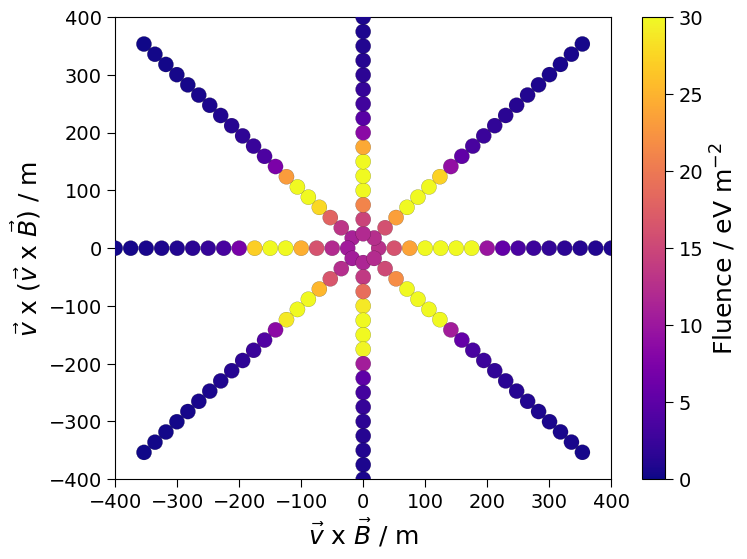

In [48]:
for sim_name in os.listdir(sim_dir):
    if not sim_name.startswith("SIM"):
        continue
    print(sim_name)

    if sim_name != "SIM000134.hdf5":
        continue
    
    results_path = os.path.join(sim_dir, sim_name)

    if not os.path.exists(results_path):
        print(f"Results file {results_path} does not exist. Skipping...")
        continue

    f_h5 = h5py.File(results_path, "r")

    ant_positions_ground, truth_traces, zenith, azimuth, magnetic_field_vector, delta_t, xmax = get_properties_from_hdf5(f_h5)

    print(xmax)
    

    transformer = cstrafo(
        zenith, azimuth, magnetic_field_vector
    )

    # print(ant_positions_ground)

    antenna_positions_vvB = transformer.transform_to_vxB_vxvxB(
        ant_positions_ground, core=np.array([0,0,7.6])
    )

    fluences = get_fluences(truth_traces, delta_t=delta_t, pol_axis=0, sample_axis=2)

    fig, ax = plt.subplots(figsize=(8,6))

    # ax.set_title(sim_name)

    ax.tick_params(axis='both', which='major', labelsize=14, size=6)
    ax.tick_params(axis='both', which='minor', labelsize=14, size=4)

    sc = ax.scatter(antenna_positions_vvB[:,0], antenna_positions_vvB[:,1],c=fluences, cmap=fluence_cmap, norm=fluence_norm, s=120.0, edgecolor='black', linewidth=0.1, zorder=10)
    ax.set_xlabel(r"$\vec{v}$ x $\vec{B}$ / m", fontsize=18)
    ax.set_ylabel(r"$\vec{v}$ x ($\vec{v}$ x $\vec{B}$) / m", fontsize=18)

    cbar = fig.colorbar(sc, ax=ax)
    cbar.ax.set_ylabel("Fluence / eV m$^{-2}$", fontsize=18)
    cbar.ax.tick_params(axis='both', which='major', labelsize=14, size=6)

    ax.set_xlim(-400, 400)
    ax.set_ylim(-400, 400)

    f_h5.close()